In [310]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std
import time

In [311]:
# 2 choices

# 1. with simulator on nicelab, user lvm
#   RMQ_HOST=$(minikube ip) ipython3
#   paste the code

# 2. local with image eg from nicelab:  /data/lvm/sci/agcam/east/20220927/lvm.sci.agcam.east_00003730.fits
#    python > 3.8
#    pip3 install sdss-lvmagp astrometry
#    ipython3

from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

In [312]:

import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

from IPython.display import clear_output

await lvm.sci.foc.start()
await lvm.sci.foc.status()

try:
    await lvm.sci.pwi.start()
    await lvm.sci.pwi.setConnected(True, statusTick=1.0)
    await lvm.sci.pwi.status()

except Exception as ex:
    print(ex)

await lvm.sci.agc.start()



In [139]:
import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

# Load images

['/data/lvm/sci/agcam/east/20230221/lvm.sci.agcam.east_00000068.fits', '/data/lvm/sci/agcam/center/20230221/lvm.sci.agcam.center_00000068.fits', '/data/lvm/sci/agcam/west/20230221/lvm.sci.agcam.west_00000068.fits']


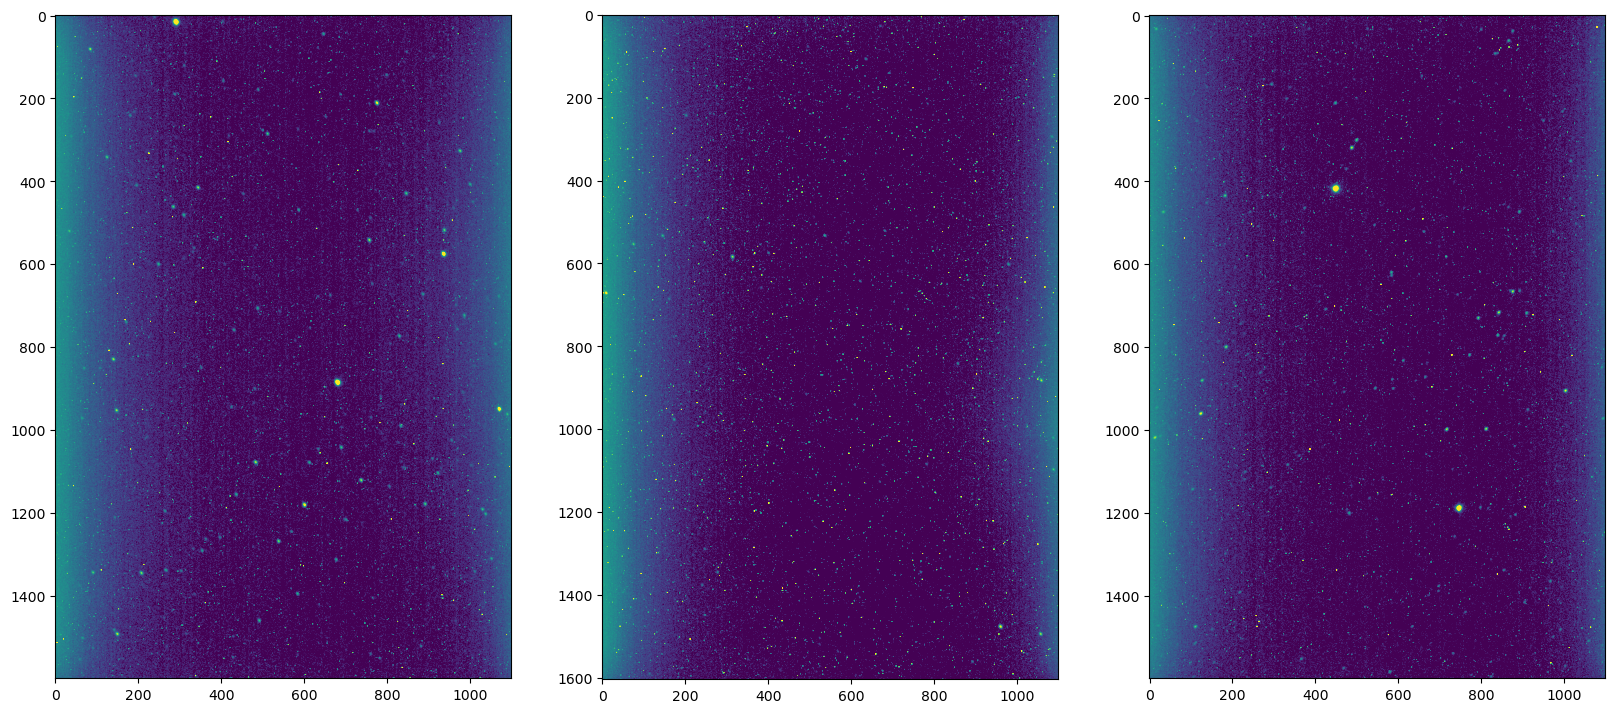

In [ ]:
exptime = 5

rc = await lvm.sci.agc.expose( exptime)
filenames = rc.flatten().unpack("*.filename")
print(filenames)

with fits.open(filenames[0]) as hdul:
    data_east = hdul[0].data
    

with fits.open(filenames[1]) as hdul:
    data_center = hdul[0].data    
    
with fits.open(filenames[2]) as hdul:
    data_west = hdul[0].data
    

    
data_center_binned = (data_center[::2,::2].astype(float)+
                      data_center[1::2,::2].astype(float)+
                      data_center[::2,1::2].astype(float)+
                      data_center[1::2,1::2].astype(float))/4

image_list = [data_east,data_center_binned,data_west]

fig,(ax1,ax2,ax3) = plt.subplots(figsize=(20,10),ncols=3)

ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=1000))
ax2.imshow(data_center_binned.T,norm=LogNorm(vmin=50, vmax=1000))
ax3.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=1000))

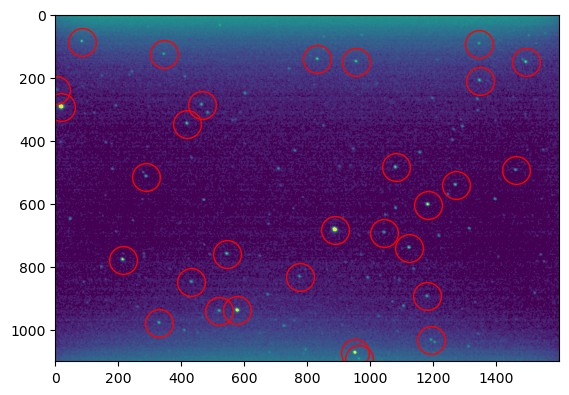

solution.best_match().center_ra_deg=89.08754893379657
solution.best_match().center_dec_deg=7.448244774629195
solution.best_match().scale_arcsec_per_pixel=1.0096156331601367
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 89.019582797766  7.48865242683519  
CRPIX : 899.8115992147533  823.5572604584372  
CD1_1 CD1_2  : -9.8338577246536e-06  -0.00028038506481048  
CD2_1 CD2_2  : 0.000280178694514373  -9.5182080370312e-06  
NAXIS : 0  0


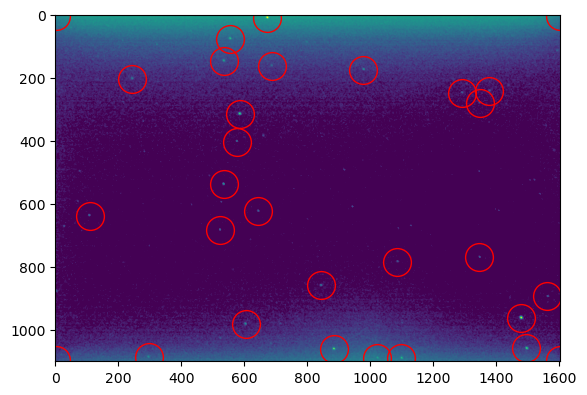

solution.best_match().center_ra_deg=88.58612067889045
solution.best_match().center_dec_deg=7.4519180508139735
solution.best_match().scale_arcsec_per_pixel=1.0099288776833681
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 88.64145993091705  7.433327390934894  
CRPIX : 874.6056795223946  742.6990376548565  
CD1_1 CD1_2  : 1.00203132273837e-05  0.000280313805996533  
CD2_1 CD2_2  : -0.00028039814793618  1.00658208905336e-05  
NAXIS : 0  0


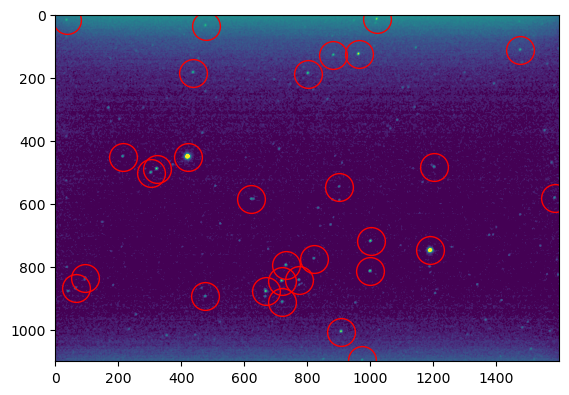

solution.best_match().center_ra_deg=88.09666020175491
solution.best_match().center_dec_deg=7.439676345023429
solution.best_match().scale_arcsec_per_pixel=1.0099402138857034
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 88.12257074464475  7.39554134835032  
CRPIX : 650.1307610156738  641.152847020433  
CD1_1 CD1_2  : -9.5556028452978e-06  0.000280378083365699  
CD2_1 CD2_2  : 0.000280382126336375  9.3241968517404e-06  
NAXIS : 0  0


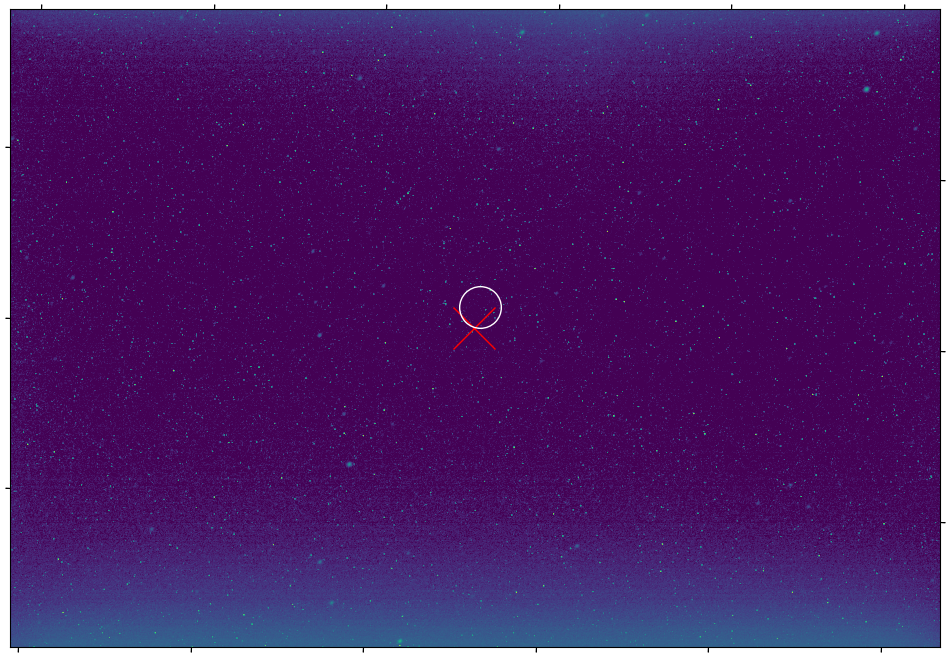

In [324]:
# Run DAOphot and Astrometry

wcs_results = []
touple_list = []

for ind, image_orig in enumerate(image_list):
    image = median_filter(image_orig,size=4)#gaussian_filter(image_orig,sigma=5)
    bkg_sigma = mad_std(image)  
    #image_orig[image_orig>60000] = float("nan")
    daofind = DAOStarFinder(fwhm=5, threshold=2 * bkg_sigma)
    sources = daofind(image)  

    sources.sort("flux")
    sources.reverse()
    sources = sources[:30]

    for col in sources.colnames:  

        sources[col].info.format = '%.8g'  # for consistent table output

    #print(sources)  
    fig,ax1 = plt.subplots(figsize=(8,4.5))

    ax1.imshow(image,norm=LogNorm(vmin=50, vmax=1000))
    ax1.plot(sources["xcentroid"],sources["ycentroid"],"o",markerfacecolor="none",markeredgecolor="r",ms=20)
    plt.show()

    logodds_callback = astrometry.Action.STOP

    solution = solver.solve(
    stars_xs=sources['xcentroid'],
    stars_ys=sources['ycentroid'],
    size_hint=astrometry.SizeHint(
        lower_arcsec_per_pixel=0.9,#arcsec_per_pixel-0.1,
        upper_arcsec_per_pixel=1.1,#arcsec_per_pixel+0.1,
    ),
    position_hint=None,
    #position_hint=astrometry.PositionHint(
    #    ra_deg=57.4,
    #    dec_deg=24.15,
    #    radius_deg=5,
    #),
    #solve_id=None,
    #tune_up_logodds_threshold=None,#14.0, # None disables tune-up (SIP distortion)
    #output_logodds_threshold=21.0,
    #logodds_callback=lambda logodds_list: logodds_callback
    solution_parameters=astrometry.SolutionParameters(
        logodds_callback=lambda logodds_list: astrometry.Action.STOP,
    ),
    )
    #log.debug("Solve done")

    if solution.has_match():
        print(f"{solution.best_match().center_ra_deg=}")
        print(f"{solution.best_match().center_dec_deg=}")
        print(f"{solution.best_match().scale_arcsec_per_pixel=}")
        wcs = astropy.wcs.WCS(solution.best_match().wcs_fields)
        wcs_results.append(wcs)
        touple_list.append((image_orig,wcs))
        pixels = wcs.all_world2pix(
            [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
            0,
        )
        print(f"{wcs}")
    else:
        wcs_results.append(None)
        print("No Match!")
        
        
wcs_east = wcs_results[0]
wcs_center = wcs_results[1]
wcs_west = wcs_results[2]

east_center = wcs_east.pixel_to_world(1600//2,1100//2)
west_center = wcs_west.pixel_to_world(1600//2,1100//2)
try:
    center_center = wcs_center.pixel_to_world(1600//2,1100//2)
except:
    pass
pa = east_center.position_angle(west_center)

sep = east_center.separation(west_center)

midpoint = west_center.directional_offset_by(pa, -sep/2) 

try:
    pix_midpoint = wcs_center.world_to_pixel(midpoint)


    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(projection=wcs_center)
    ax1.imshow(image_list[1], norm=LogNorm(vmin=50, vmax=10000))
    ax1.plot(800,550,"rx",ms=30)
    ax1.plot(pix_midpoint[0],pix_midpoint[1],"wo",ms=30,markerfacecolor="None")

    plt.show()

except:
    pass


#await lvm.sci.pwi.modelAddPoint(midpoint.ra.hour,midpoint.dec.deg)

In [328]:
await lvm.sci.pwi.modelAddPoint(midpoint.ra.hour,midpoint.dec.deg)
last_point = await lvm.sci.pwi.modelSave("{}_automated_pointing_model.pxp".format(int(time.time())))
await lvm.sci.pwi.setTracking(True)

{'is_tracking': True}

41

In [327]:
await lvm.sci.pwi.setTracking(True)

{'is_tracking': True}

In [340]:
await lvm.sci.pwi.modelDisablePoint(*range(20))#last_point["model"]["num_points_total"]-1)

Exception: Bad request

# Reproject images'

In [326]:
import reproject
from reproject.mosaicking import find_optimal_celestial_wcs

wcs_out, shape_out= reproject.mosaicking.find_optimal_celestial_wcs(touple_list)

reprojected_arrays = []
footprints = []
for index,touple in enumerate(touple_list):
    print(index)
    

    reprojected_array,current_footprint = reproject.reproject_interp(touple, wcs_out, shape_out=shape_out)
    reprojected_arrays.append(reprojected_array)
    footprints.append(current_footprint)

0
1
2


In [317]:
stack = np.array(reprojected_arrays)
stack_combined = np.nanmedian(stack,axis=0)
footprints_sum = np.sum(np.array(footprints),axis=0)

[WARNING]: All-NaN slice encountered (RuntimeWarning)
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



In [318]:
pix_array = np.array([wcs_out.world_to_pixel(center_center),wcs_out.world_to_pixel(west_center),wcs_out.world_to_pixel(east_center)])

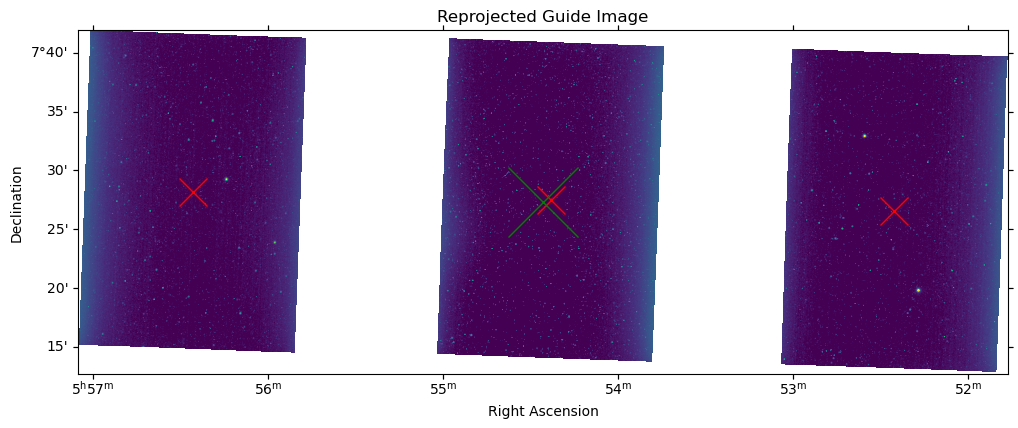

In [320]:
pix_midpoint = wcs_out.world_to_pixel(midpoint)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(projection=wcs_out)
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
#ax1.plot(gaia_pixel_repro[0],gaia_pixel_repro[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected Guide Image')

ax1.plot(pix_array[:,0],pix_array[:,1],"rx",ms=20)

ax1.plot(pix_midpoint[0],pix_midpoint[1],"gx",ms=50)


In [128]:
midpoint.ra.hour

5.554730164827567

In [129]:
midpoint.dec.deg

-5.106022577770433

{'model': {'filename': '2023-02-16-lco-skyw-7.pxp',
  'num_points_enabled': 13,
  'num_points_total': 14,
  'rms_error_arcsec': 1107.42594702486}}

# Load and show Gaia stars 

In [ ]:
import astropy.units as u
from astroquery.gaia import Gaia

In [ ]:
#my_wcs = wcs_out
c_icrs = wcs_out.pixel_to_world(shape_out[1]//2,shape_out[0]//2)
radius = u.Quantity(0.8, u.deg)
remote_maglim=12
#j = Gaia.cone_search_async(coordinate=c_icrs, radius)
gaia_query = "SELECT source_id, ra,dec,phot_g_mean_mag FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag <= "+str(remote_maglim)+" AND 1=CONTAINS(POINT('ICRS',ra,dec), CIRCLE('ICRS',"+str(c_icrs.ra.deg)+","+str(c_icrs.dec.deg)+", "+str(radius.value)+"))"
print("Gaia query: ",gaia_query)
j = Gaia.launch_job_async(gaia_query)
cat = j.get_results()
#print("Gaia query: ",gaia_query)
print(f'{len(cat)} stars found within {radius}')


Gaiastars = SkyCoord(cat["ra"],cat["dec"],unit="deg")
#gaia_pixel_orig = wcs.world_to_pixel(Gaiastars)
gaia_pixel = wcs_out.world_to_pixel(Gaiastars)
        
gaia_selection = (0 < gaia_pixel[0]) & (gaia_pixel[0] < shape_out[1]) & (0 < gaia_pixel[1]) & (gaia_pixel[1] < shape_out[0])
cat = cat[gaia_selection]
Gaiastars = SkyCoord(cat["ra"],cat["dec"],unit="deg")
gaia_pixel = wcs_out.world_to_pixel(Gaiastars)
print("{} of these are actually in the FOV".format(len(cat)))

In [ ]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(projection=wcs_results[0])
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
ax1.plot(gaia_pixel[0],gaia_pixel[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
#ax1.coords['ra'].set_axislabel('Right Ascension')
#ax1.coords['dec'].set_axislabel('Declination')
#ax1.set_title('2MASS K-band')

for index,entry in enumerate(cat):
    ax1.text(gaia_pixel[0][index]+25,gaia_pixel[1][index],"{:.1f}".format(entry["phot_g_mean_mag"]),color="w",alpha=0.8)
    
#ax1.set_xlim(0,1600)
#ax1.set_ylim(0,1100)

In [ ]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(stack_combined, origin='lower', vmin=100, vmax=10000)
ax1.set_title('Mosaic')
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(footprints_sum, origin='lower')
ax2.set_title('Footprint')

In [ ]:
header = wcs_out.to_header()
hdu = fits.PrimaryHDU(stack_combined,header=header)


hdul = fits.HDUList([hdu])
hdul.writeto('full_mater_mosaic.fits',overwrite=True)